In [ ]:
import numpy as np
import pandas as pd
import pathlib

data_path = pathlib.Path("./data/")

from src.utils import *
import src.bokeh_plot as bokeh_plot

import bokeh.plotting as bkp
import bokeh.models as bkm
import bokeh.layouts as bkl
from bokeh.palettes import d3
from bokeh.resources import CDN
from bokeh.embed import file_html, components
bkp.output_notebook()

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.stats import f, t
from scipy.optimize import minimize

from tqdm import tqdm
import datetime

%load_ext autoreload
%autoreload 2

# Get data

In [2]:
! rm -rf full_data.csv
! wget https://covid.ourworldindata.org/data/ecdc/full_data.csv
! mv full_data.csv data/ecdc_full_data.csv

--2020-03-31 19:25:24--  https://covid.ourworldindata.org/data/ecdc/full_data.csv
Résolution de covid.ourworldindata.org (covid.ourworldindata.org)… 142.93.108.123, 2a03:b0c0:3:e0::1b:1
Connexion à covid.ourworldindata.org (covid.ourworldindata.org)|142.93.108.123|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 234930 (229K) [text/csv]
Sauvegarde en : « full_data.csv »

full_data.csv       100%[===================>] 229,42K   320KB/s    ds 0,7s    

2020-03-31 19:25:25 (320 KB/s) — « full_data.csv » sauvegardé [234930/234930]



In [3]:
data = pd.read_csv(data_path / "ecdc_full_data.csv")
data = data.rename(columns={"Total confirmed cases of COVID-19" : "total_cases"})
data['date'] = data.date.apply(pd.to_datetime)
data['date_str'] = data.date.apply(lambda x: x.strftime('%d/%m/%Y'))
data = data_china_smoothing(data, n_days_smoothing=6, n_cases_true=5000)
data.head(2)

,date,location,new_cases,new_deaths,total_cases,total_deaths,date_str
0,2019-12-31,Afghanistan,0,0,0,0,31/12/2019
1,2020-01-01,Afghanistan,0,0,0,0,01/01/2020


# Modélisation bi-modale

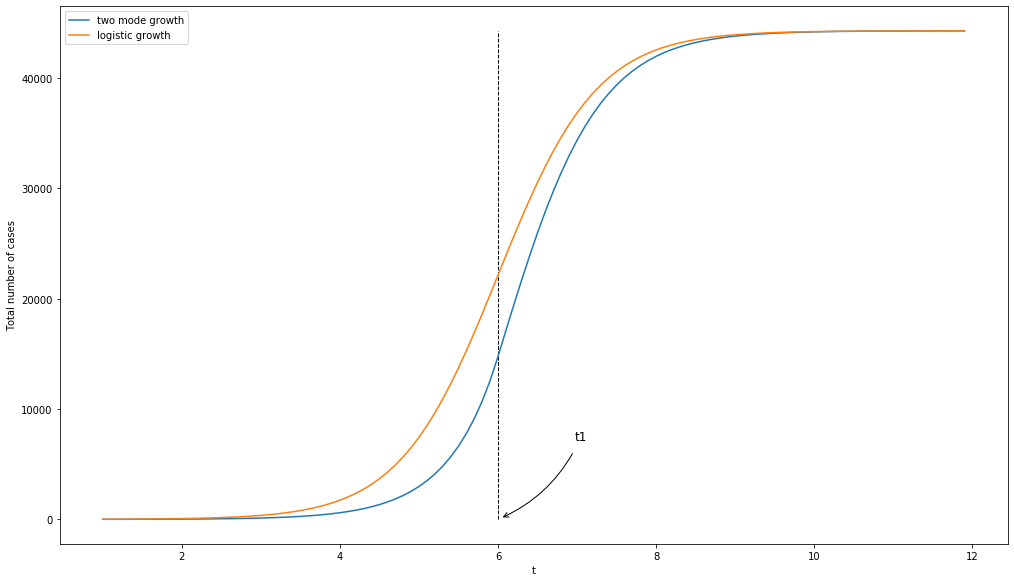

In [98]:
t = np.arange(1, 12, 0.1)
ind_containment = 50
t1 = t[ind_containment]
non_containment = np.zeros(ind_containment)
containment = np.ones(t.shape[0] - ind_containment)
y = np.hstack((non_containment, containment))

x0 = 6
r1 = 1.6
r2 = 1.6


K = r1/r2 * np.exp(r1*t1) * (1 / sigmoid(t1, x0, 1, r2) * 1 / (1 - sigmoid(t1, x0, 1, r2)))
a = np.exp(r1*t1) - K * (1 / (1 + np.exp(-r2*(t1-x0))))

fig, ax = plt.subplots(figsize=(14, 8))

ax.plot([t1, t1], [0, max(sigmoid(t, x0, K + a, r1))], 'k--', linewidth=1)
ax.plot(t, two_mode_growth(t, x0, K, r1, r2, y, t1), label='two mode growth')

ax.annotate('t1', xy=(t1, 0),  xycoords='data',
            xytext=(0.55, 0.2), textcoords='axes fraction', size=12, weight=500,
            horizontalalignment='center', verticalalignment='center',
            arrowprops=dict(arrowstyle="->",
                            color="k",
                            patchB=None,
                            shrinkA=10,
                            shrinkB=5,
                            connectionstyle="arc3,rad=-0.2",
            ))

ax.plot(t, sigmoid(t, x0, K + a, r1), label='logistic growth')
plt.legend()
plt.tight_layout()
plt.xlabel('t')
plt.ylabel('Total number of cases')
plt.savefig("img/difs-two-models.png", dpi=200, bbox_inches='tight')
plt.show()

# Compute predictions

In [5]:
df_all_prediction = pd.DataFrame()
countries = ["France", "Italy"]

for country in tqdm(countries, position=0, leave=True):
    print("fit model for " + country + " data")
    df = get_country_and_min_count(data, country)
    
    fitted_sigmoid_df, paramters_values_sigmoid = compute_moving_predictions(df, n_prediction=90, n_bootstrap=3, 
                                                                             min_data=df.shape[0]-5, step=1, loss='MSE', linear_proba=True)
    fitted_sigmoid_df["location"] = np.repeat(country, repeats=fitted_sigmoid_df.shape[0])
    
    df_all_prediction = pd.concat([df_all_prediction, fitted_sigmoid_df])
    
df_all_prediction

  0%|          | 0/2 [00:00<?, ?it/s]

fit model for France data


 50%|█████     | 1/2 [00:03<00:03,  3.14s/it]

fit model for Italy data


100%|██████████| 2/2 [00:05<00:00,  2.78s/it]


,date,date_str,25%,median,75%,derivative,median_display,date_end_train,location
0,2020-02-27,27/02/2020,127.367212,138.265781,143.814168,28.587045,138,2020-03-26,France
1,2020-02-28,28/02/2020,156.612030,170.013023,176.835377,35.130839,170,2020-03-26,France
2,2020-02-29,29/02/2020,192.546499,209.022335,217.410071,43.161232,209,2020-03-26,France
3,2020-03-01,01/03/2020,236.687943,256.940879,267.251510,53.010165,256,2020-03-26,France
4,2020-03-02,02/03/2020,290.891263,315.782274,328.454117,65.080749,315,2020-03-26,France
...,...,...,...,...,...,...,...,...,...
84,2020-05-16,16/05/2020,128774.983662,128838.150365,129665.890659,1.194534,"128,838",2020-03-31,Italy
85,2020-05-17,17/05/2020,128776.072455,128839.239691,129666.986984,0.990485,"128,839",2020-03-31,Italy
86,2020-05-18,18/05/2020,128776.975259,128840.142938,129667.896033,0.821288,"128,840",2020-03-31,Italy
87,2020-05-19,19/05/2020,128777.723843,128840.891890,129668.649797,0.680993,"128,840",2020-03-31,Italy


# Plot data

In [17]:
select, button_prediction, slider, p = bokeh_plot.generate_plot(data, df_all_prediction)

bkp.show(bkm.Column(bkm.Row(select, button_prediction, slider), p, sizing_mode='stretch_width'))

# Exemple of parameters distibution

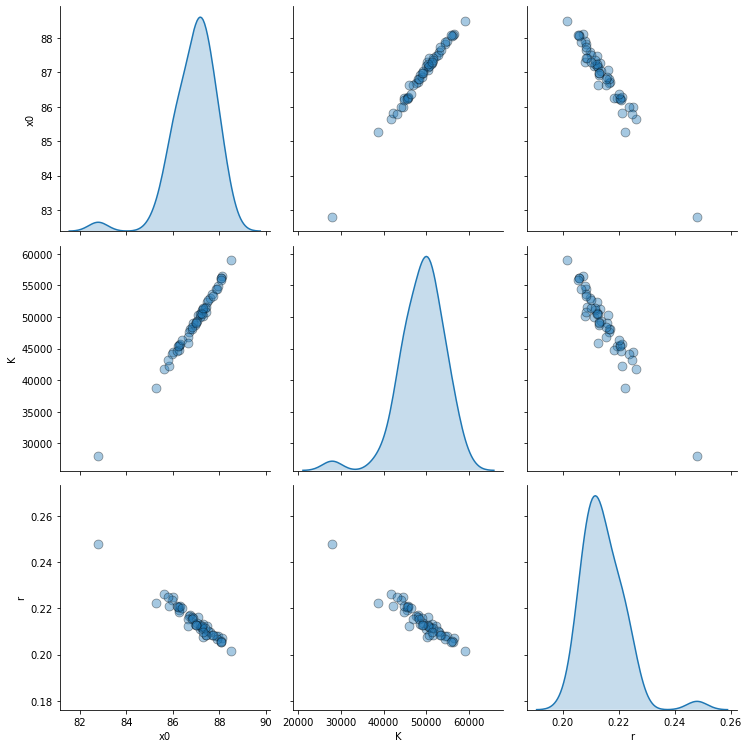

In [49]:
sigmodel = SigmoidModel(n_bootstrap=50)
sigmodel.fit(get_country(data, 'France'))
sigmodel.plot_params_distribution(height = 3.5, **{'alpha': 0.4, 's': 80, 'edgecolor': 'k'})
plt.tight_layout(h_pad=1.1)
plt.savefig("./img/pairplot-parameters.png", dpi=200, bbox_inches='tight')

In [ ]:
lockdown = {
    "China": pd.Timestamp("23/01/2020"),
    "Italy": pd.Timestamp("23/02/2020"),
    "South Korea": pd.Timestamp("23/02/2020"),
}

inflection = {
    "Italy": pd.Timestamp("16/03/2020"),
}

In [ ]:
lockdown["China"]

In [ ]:
df = get_country_and_min_count(data, "Italy")
df[df.date == lockdown["Italy"]]
df = df.reset_index()

# OLS estimation with K fixed

In [ ]:
from sklearn.linear_model import LinearRegression as lr

def logit(x):
    return np.log(x/(1-x))

def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))

    
plt.figure(figsize=(14, 7))
plt.plot(t, df.total_cases, '.')
for K in range(50000, 100000, 5000):
    y = df.total_cases / K
    X = (df.index.values + 1).reshape(-1, 1)

    model = lr()
    model.fit(X, logit(y))

    print(f"r = {model.coef_[0]}")
    print(f"a = {np.exp(-model.intercept_)}")


    t_pred = np.arange(1, 100, 1)
    pred = inv_logit(model.predict(t_pred.reshape(-1, 1))) * K
    plt.plot(t_pred, pred)
plt.show()